# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [1]:
## This cell: libraries and settings

import io
import os
import logging
import sys
import pyndri
import time
import math
import collections
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import combinations
from collections import defaultdict
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
import re
import pprint
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
start_time = time.time()

In [2]:
## This cell: provided code, writing to .run files and inverted index creation

import pyndri
index = pyndri.Index('index/')
token2id, id2token, _ = index.get_dictionary()

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics


#with open('./ap_88_89/test_topic', 'r') as f_topics:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

#______________________we added a list to keep the ext_doc and the tokens in every doc___________
doc_list = []
max_doc_len = 0
ex_to_id = {}

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    
    #--------------------------------------
    doc_list.append((ext_doc_id,doc_token_ids))
    if(len(doc_token_ids) > max_doc_len):
        max_doc_len = len(doc_token_ids)
    ex_to_id[ext_doc_id] = int_doc_id
    #--------------------------------------
    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 68.48800206184387 seconds.


In [ ]:
def run_retrieval(model_name, score_fn, hyper_param):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    #-----------------------------------------
    if model_name != 'tfidf' and model_name != 'BM25':
        model_name = model_name + str(hyper_param)
    #-----------------------------------------
    run_out_path = str('models/eval/') + '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()


    print('Retrieving using', model_name)

    data = collections.defaultdict(list)

    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    
    #for query_id, _ in queries.items():
    for query_id, query_terms in tokenized_queries.items():
        
        score_per_doc = Counter()
        '''
        We do not go through all documents, we just go through the all documents relate to query term.
        For example if we have 5 docs and Q1 = w1 w2 and w1 is inside the doc1 & doc2, w2 is inside doc3
        , then we go through doc1, doc2, doc3
        '''        
        #------------------------docs_to_check = sum of all documents for q:-------------------------
        
        docs_to_check = set([inverted_index[term_id].keys() for term_id in query_terms][0])
        
        '''
        We check the score for every term of a query for every doc related to that query and assign some score
        to them.
        In tf-idf when the term is not inside the that doc, we return 0.
        In the smoothing methods, we assign some probability to the unseen terms.
        '''
        #--------------------------find the score(query, doc)-----------------------------------------
        #for query_term_id in tokenized_queries[query_id]:
        for query_term_id in query_terms:
            for int_doc_id in docs_to_check:
                document_term_freq = get_tf(int_doc_id, query_term_id)
                score_per_doc[int_doc_id] += score_fn(int_doc_id, query_term_id, document_term_freq,hyper_param)
                
        #------------------------make data set to write in run file------------------------------------        
        for int_doc_id in score_per_doc:
            data[query_id].append((score_per_doc[int_doc_id], doc_list[int_doc_id - 1][0]))

    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)


In [ ]:
def get_tf(int_document_id, query_term_id):
    '''
    Returns term frequency (tf_t) for a document
    https://docs.quantifiedcode.com/python-anti-patterns/correctness/not_using_get_to_return_a_default_value_from_a_dictionary.html    
    '''
    if len(inverted_index[query_term_id]) == 0:
        return 0
    else:
        return float(inverted_index.get(query_term_id, 0).get(int_document_id, 0))

def collection_freq(query_term_id):
    #Returns collection frequency
    return collection_frequencies.get(query_term_id, 0)

def calc_p_wc(query_term_id):
    p_wc = collection_freq(query_term_id) / total_terms
    return p_wc

## Scoring Methods:

#### TF-IDF without normalization:

In [ ]:
def tfidf(int_document_id, query_term_id, document_term_freq,num_docs):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """    
    score = document_term_freq * math.log10(num_docs/len(inverted_index[query_term_id]))
    return score



In [ ]:
num_documents = index.maximum_document() - index.document_base()
run_retrieval('tfidf', tfidf, num_documents)

#### BM25 with k1=1.2 and b=0.75:

In [ ]:
def BM25(int_document_id, query_term_id, document_term_freq,hyper_param):

    '''
    BM25 with document length normalization
    tf = document_term_freq
    l_avg = avg_doc_length
    l_d = document_lengths[int_document_id]
    idf = math.log10(num_documents/len(inverted_index[query_term_id])
    '''
    k1=hyper_param[0]
    b=hyper_param[1]


    w_t_numerator = (k1+1) * document_term_freq * math.log10(num_documents / len(inverted_index[query_term_id]))
    w_t_denominator = (k1 * (1-b + (b * document_lengths[int_document_id] / avg_doc_length))) + document_term_freq

    w_t =  w_t_numerator/w_t_denominator
    
    return w_t


In [ ]:

'''    
k1=1.2
b=0.75
'''
hyper_param = [1.2,0.75]
run_retrieval('BM25', BM25,hyper_param)

#### Jelinek-Mercer at 𝛌 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
def jelinek_mercer(int_document_id, query_term_id, document_term_freq,lmbda):
    
    tf_wd = document_term_freq
    d = document_lengths[int_document_id]
    p_wC = calc_p_wc(query_term_id)
    
    pbt_lambda = (1 - lmbda)*(p_wC) + lmbda*(tf_wd/d)
    return np.log10(pbt_lambda)


In [ ]:
for hyper_param in np.arange(0, 1, 0.1): 
    hyper_param = round(hyper_param, 1)
    run_retrieval('jelinek_mercer', jelinek_mercer,hyper_param)

 #### Dirichelet at 𝛍 = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]:

In [ ]:
def dirichlet(int_document_id, query_term_id, document_term_freq, mu):
    '''
    score(d,q) = log p(q|d) = sum(log p_mu(w_i|d))
    p_mu(w_i|d) = [tf[w,d] + mu*p(w|C)] / [len_d + mu]
    '''    
    p_wd_numerator = document_term_freq + (mu * calc_p_wc(query_term_id)) 
    p_wd_denominator = document_lengths[int_document_id] + mu #led_d + mu
    p_wd = p_wd_numerator / p_wd_denominator    
    score =  math.log10(p_wd)
    return score


In [ ]:
for hyper_param in range(500,5500, 500):
    run_retrieval('dirichlet', dirichlet, hyper_param)

#### Absolute Discounting at 𝛅 =  [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:

In [ ]:
#formula from : https://dl.acm.org/citation.cfm?id=384019
def absolute_discounting(int_document_id, query_term_id, document_term_freq, delta):
    
    tf_wd = document_term_freq
    d = document_lengths[int_document_id]
    #d_u = number of unique words in d
    d_u = unique_terms_per_document[int_document_id]
    p_wC = calc_p_wc(query_term_id)
    
    #seen words probability
    seen_words = max((tf_wd - delta), 0)/d
    
    #unseen words probability
    unseen_words = delta*(d_u/d)*p_wC

    return (seen_words + unseen_words)


In [ ]:
for hyper_param in np.arange(0, 1, 0.1):
    hyper_param = round(hyper_param, 1)
    run_retrieval('absolute_discounting', absolute_discounting,hyper_param)
#run_retrieval('absolute_discounting 0.5', absolute_discounting_05)
#run_retrieval('absolute_discounting 0.9', absolute_discounting_09)

#### PLM with 𝛔 = 50, using Dirichlet smoothing with 𝛍 = 3000, scoring with KL-divergence and Best position strategy:

In [ ]:
#precalc kernels:
def precaculate_kernel(kernel_func,max_doc_len, sig):
    precomputed_list = []
    for delta_position in range(max_doc_len):
        precomputed_list.append(kernel_func(delta_position,sig))
    return precomputed_list
        
def guas_kernel(delta_position,sig):
    k = math.exp(-1 * ((delta_position)**2) / (2*(sig**2)))
    return k        
        
    
def triangle_kernel(delta_position,sig):
    if delta_position <= sig:
        return (1 - (delta_position/float(sig)))
    else:
        return 0

def cosine_kernel(delta_position,sig):
    if delta_position <= sig:
        return 0.5 * (1 + math.cos(delta_position *math.pi/float(sig)))
    else:
        return 0  
    
def circle_kernel(delta_position,sig):
    if delta_position <= sig:
        return math.sqrt(1 - (delta_position/float(sig))**2)
    else:
        return 0    
    
    
def passage_kernel(delta_position,sig):
    if delta_position <= sig:
        return 1
    else:
        return 0
#---------------------------------------------------------------------------------------
#--------make a dict of dicts containing query_id : p(w|Q) for the that query-----------
def make_p_WQ_dict(query_tokens):
    p_wQ_dict = {}
    for query_id, query_terms in query_tokens.items(): 
        p_wQ_dict[query_id] = {query_term_id : float(query_terms.count(query_term_id)/len(query_terms)) 
                               for query_term_id in query_terms}
    return p_wQ_dict
#---------------------------------------------------------------------------------------
sig = 50

start_time = time.time()
precomputed_gaus = precaculate_kernel(guas_kernel,max_doc_len, sig)
print('gaus_kernel  creation took', time.time() - start_time, 'seconds.')

start_time = time.time()
precomputed_triangle = precaculate_kernel(triangle_kernel,max_doc_len, sig)
print('triangle_kernel creation took', time.time() - start_time, 'seconds.')

start_time = time.time()
precomputed_cosine = precaculate_kernel(cosine_kernel,max_doc_len, sig)
print('cosine_kernel creation took', time.time() - start_time, 'seconds.')

start_time = time.time()
precomputed_circle = precaculate_kernel(circle_kernel,max_doc_len, sig)
print('circle_kernel creation took', time.time() - start_time, 'seconds.')

start_time = time.time()
precomputed_passage = precaculate_kernel(passage_kernel,max_doc_len, sig)
print('passage_kernel creation took', time.time() - start_time, 'seconds.')
#---------------------------------------------------------------------------
start_time = time.time()
p_wQ_dict = make_p_WQ_dict(tokenized_queries)
print('p_wQ_dict creation took', time.time() - start_time, 'seconds.')


In [ ]:
def find_position_score(word_pos_in_doc, current_position , mu, p_wQ, precomputed_kernel):
    
    cwi_prime_matrix = Counter()    
    for doc_info in word_pos_in_doc:
        j = doc_info[0]
        delta_position = abs(current_position - j)
        cwi_prime_matrix[doc_info[1]] += precomputed_kernel[delta_position]
    z_i = sum(cwi_prime_matrix.values())    

    score_q_i =0        
    for word_id in p_wQ.keys():
        p_wd_numerator = cwi_prime_matrix.get(word_id,0) + (mu * calc_p_wc(word_id)) 
        p_wd_denominator = z_i + mu #led_d + mu
        p_wd_i = p_wd_numerator / p_wd_denominator
        score_q_i += (p_wQ[word_id] * np.log10(p_wQ[word_id]/p_wd_i))
    score_q_i = -1 * score_q_i
    return score_q_i


In [ ]:
# based on baseline in: https://pdfs.semanticscholar.org/ebf5/8dbe6d58845f3253d00e25e8c7280797fc80.pdf
def plm_run_retrieval(model_name, kernel_list,hyper_param, doc_list,p_wQ_dict):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param kernel_fn: the scoring function (a function - see below for an example) 
    """
    model_name = model_name + "_" +str(hyper_param)
    #-----------------------------------------
    run_out_path = str('models/eval/') + '{}.run'.format(model_name)
    if os.path.exists(run_out_path):
        return
    retrieval_start_time = time.time()
    print('Retrieving using', model_name)
    
    data = collections.defaultdict(list)   
    
    '''query= ['133','93']
    terms = tokenized_queries['133'],tokenized_queries['93']
    for i in range(len(query)):
        query_id = query[i]
        query_terms = terms[i]'''
    
    for query_id, query_terms in tokenized_queries.items(): 
        score_per_doc = {}
        docs_to_check = set([inverted_index[term_id].keys() for term_id in tokenized_queries[query_id]][0])
        print(query_id,len(docs_to_check))
        for int_doc_id in docs_to_check:
            score_pos = []
            word_pos_in_doc=[(j,w) for w in query_terms 
                               for j in np.where(np.array(doc_list[int_doc_id-1][1]) == w)[0]]
            for pos in range(len(doc_list[int_doc_id-1][1])):
                score_pos.append(find_position_score(word_pos_in_doc, pos , hyper_param, p_wQ_dict[query_id],kernel_list))
            score_per_doc[int_doc_id] = max(score_pos)


        #------------------------make data set to write in run file------------------------------------        
        for int_doc_id in score_per_doc:
            data[query_id].append((score_per_doc[int_doc_id], doc_list[int_doc_id-1][0]))

    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)


In [ ]:
mu = 3000


start_time = time.time()
plm_run_retrieval("plm_gaus", precomputed_gaus ,mu, doc_list,p_wQ_dict)
print('precomputed_gaus creation took', time.time() - start_time, 'seconds.')

start_time = time.time()
plm_run_retrieval("plm_triangle", precomputed_triangle ,mu, doc_list,p_wQ_dict)
print('precomputed_triangle creation took', time.time() - start_time, 'seconds.')

start_time = time.time()
plm_run_retrieval("plm_cosine", precomputed_cosine ,mu, doc_list,p_wQ_dict)
print('cosine plm creation took', time.time() - start_time, 'seconds.')

start_time = time.time()
plm_run_retrieval("plm_circle", precomputed_circle ,mu, doc_list,p_wQ_dict)
print('circle plm creation took', time.time() - start_time, 'seconds.')

start_time = time.time()
plm_run_retrieval("passage", precomputed_passage ,mu, doc_list,p_wQ_dict)
print('passage creation took', time.time() - start_time, 'seconds.')

In [3]:
## This cell: parsing of results and data structures

def parse_results(results_file):
    results_lines = [l.strip('\n') for l in open(results_file, 'r').readlines()]
    eval_measure = None
    results_by_scoring = defaultdict(lambda: defaultdict(dict))
    results_by_eval = defaultdict(lambda: defaultdict(dict))
    means = defaultdict(lambda: defaultdict(float))
    
    for line in results_lines:
        if line.startswith('MODEL:'):
            scoring_method = line.split(': ')[1]
            continue
        else:
            eval_measure, query, result = line.split()
            if query == 'all':
                means[eval_measure][scoring_method] = result
            else:
                results_by_scoring[scoring_method][eval_measure][int(query)] = float(result)
                
    for scoring_method in results_by_scoring.keys():
        for eval_measure in results_by_scoring[scoring_method].keys():
            for query, result in results_by_scoring[scoring_method][eval_measure].items():
                results_by_eval[eval_measure][scoring_method][query] = float(result)

    return means, results_by_scoring, results_by_eval
    
means_validation, scoring_dict_validation, eval_dict_validation = parse_results('results_validation.txt')
means_test, scoring_dict_test, eval_dict_test = parse_results('results_test.txt')
means_validation_df = pd.DataFrame.from_dict(means_validation)
means_test_df = pd.DataFrame.from_dict(means_test)

# dict with all language model names
language_models = {
    'absolute_discounting' : [setting for setting in list(means_test['ndcg_cut_10']) 
                              if setting.startswith('absolute_discounting')],
    'dirichlet' : [setting for setting in list(means_test['ndcg_cut_10']) 
                   if setting.startswith('dirichlet')],
    'jelinek_mercer' : [setting for setting in list(means_test['ndcg_cut_10']) 
                        if setting.startswith('jelinek_mercer')],
    'plm' : [setting for setting in list(means_test['ndcg_cut_10']) 
                        if setting.startswith('plm')]
}

# ranking functions list
ranking_functions = ['tfidf', 'BM25']

# dicts for easy pretty printing of eval measure, scoring method and (requested) settings
eval_measures = {
    'ndcg_cut_10' : 'NDCG@10',
    'map_cut_1000' : 'MAP@1000',
    'P_5' : 'Precision@5',
    'recall_1000' : 'Recall@1000'
}

scoring_methods = {
    'absolute_discounting' : 'Absolute Discounting',
    'dirichlet' : 'Dirichlet',
    'jelinek_mercer' : 'Jelinek-Mercer',
    'plm' : 'PLM',
    'tfidf' : 'TFIDF',
    'BM25' : 'BM25'
}

settings = {}
for setting in means_test['ndcg_cut_10']:
    settings[setting] = {}
    if setting.startswith('absolute_discounting'):
        settings[setting]['model'] = 'Absolute Discounting'
        settings[setting]['setting'] = "$\delta$ = " + "".join(re.findall(r'[0-9.]', setting))
    elif setting.startswith('jelinek_mercer'):
        settings[setting]['model'] = 'Jelinek-Mercer'
        settings[setting]['setting'] = "$\lambda$ = " + "".join(re.findall(r'[0-9.]', setting))
    elif setting.startswith('dirichlet'):
        settings[setting]['model'] = 'Dirichlet'
        settings[setting]['setting'] = "$\mu$ = " + "".join(re.findall(r'[0-9.]', setting))
        
requested_settings = {
    'jelinek_mercer': ('$\lambda$ = 0.1', '$\lambda$ = 0.5', '$\lambda$ = 0.9'),
    'dirichlet': ('$\mu$ = 500', '$\mu$ = 1000', '$\mu$ = 1500'),
    'absolute_discounting': ('$\delta$ = 0.1', '$\delta$ = 0.5', '$\delta$ = 0.9')
}

# all validation query ids
validation_queries = list(set([int(line.split(' ')[0]) 
                               for line in open('ap_88_89/qrel_validation', 'r').readlines()]))
# all test query ids
test_queries = list(set([int(line.split(' ')[0]) 
                         for line in open('ap_88_89/qrel_test', 'r').readlines()]))

## Plots and statistics on the validation set

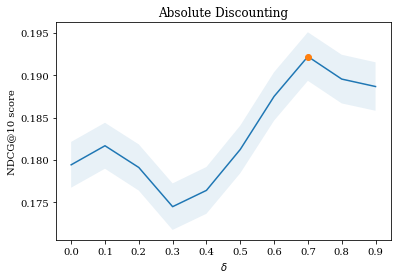

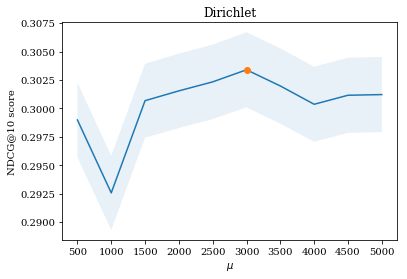

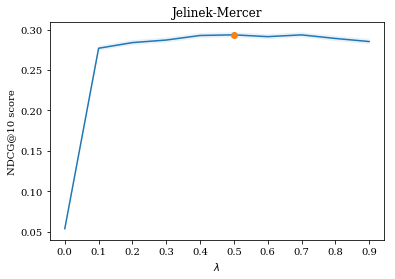

In [4]:
# plots for language models with different parameter settings on the validation set

for model in list(filter(lambda x: x != 'plm', language_models.keys())):
    pars = np.array([float(re.search(r'[0-9\.]+', setting).group(0)) for setting in language_models[model]])
    sorted_pars_idx = np.argsort(pars)
    model_results = np.array([list(eval_dict_validation['ndcg_cut_10'][setting].values()) for setting in language_models[model]])
    model_means = np.array([np.mean(results) for results in model_results])
    model_stds = np.array([np.std(results) for results in model_results])
    model_max = np.argmax(model_means)
    parameter = ('$\mu$' if model == 'dirichlet' else '$\lambda$' if model == 'jelinek_mercer' else '$\delta$')
    plt.xticks(pars[sorted_pars_idx])
    plt.xlabel(parameter)
    plt.ylabel('NDCG@10 score')
    plt.title(scoring_methods[model])
    plt.fill_between(pars[sorted_pars_idx], model_means[sorted_pars_idx] + 0.01*model_stds[sorted_pars_idx], 
                     model_means[sorted_pars_idx] - 0.01*model_stds[sorted_pars_idx], alpha=0.1)
    plt.plot(pars[sorted_pars_idx], model_means[sorted_pars_idx])
    plt.plot(pars[model_max], model_means[model_max], 'o')
    plt.savefig('hyperparameter_plot_' + model + '.png', format='png', dpi=900)
    plt.show()

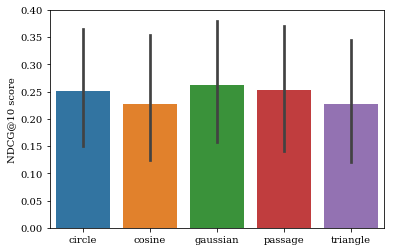

[('circle', '0.2520'), ('cosine', '0.2265'), ('gaussian', '0.2628'), ('passage', '0.2528'), ('triangle', '0.2272')]
[('circle', 0.31266590007013345), ('cosine', 0.3178248584082469), ('gaussian', 0.3234126731523605), ('passage', 0.3184043177401267), ('triangle', 0.31453889794780904)]


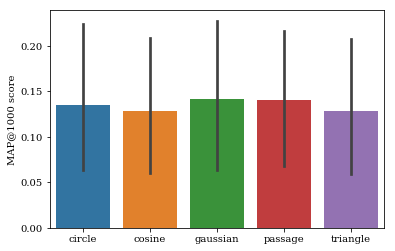

[('circle', '0.1351'), ('cosine', '0.1286'), ('gaussian', '0.1420'), ('passage', '0.1407'), ('triangle', '0.1289')]
[('circle', 0.2173764885834917), ('cosine', 0.21312513718470658), ('gaussian', 0.22257632658383858), ('passage', 0.21994704738994691), ('triangle', 0.213081484179175)]


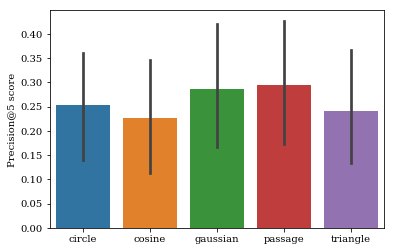

[('circle', '0.2533'), ('cosine', '0.2267'), ('gaussian', '0.2867'), ('passage', '0.2933'), ('triangle', '0.2400')]
[('circle', 0.3343982987729187), ('cosine', 0.32550814975289877), ('gaussian', 0.3451891590933232), ('passage', 0.34922135609890126), ('triangle', 0.3282275633357645)]


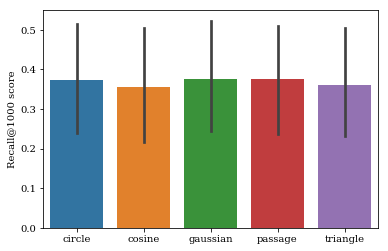

[('circle', '0.3723'), ('cosine', '0.3550'), ('gaussian', '0.3756'), ('passage', '0.3756'), ('triangle', '0.3619')]
[('circle', 0.39200665243788346), ('cosine', 0.3901752663725482), ('gaussian', 0.39274188256693765), ('passage', 0.3909911699628124), ('triangle', 0.3890808892762532)]


In [5]:
# plots for comparison between PLM kernels

for eval_measure in list(eval_dict_validation.keys()):
    data_things = sorted([(re.search(r'(?<=\_).*(?=\_)', setting).group(0), 
                    list(scoring_dict_validation[setting][eval_measure].values())) 
                          for setting in language_models['plm']])
    sns.barplot(data=[dat[1] for dat in data_things])
    plt.xticks(np.arange(len(data_things)), [thing[0] for thing in data_things])
    plt.ylabel(eval_measures[eval_measure] + ' score')
    plt.savefig('plm_kernels_' + eval_measures[eval_measure] + '.eps', format='eps', dpi=900)
    plt.show()

    data_means = sorted([(re.search(r'(?<=\_).*(?=\_)', setting).group(0), 
                    means_validation[eval_measure][setting]) 
                   for setting in language_models['plm']])
    data_stds = sorted([(re.search(r'(?<=\_).*(?=\_)', setting).group(0), 
                    np.std(list(scoring_dict_validation[setting][eval_measure].values()))) 
                   for setting in language_models['plm']])
    print(data_means)
    print(data_stds)

In [6]:
# t-tests and multiple comparisons between PLM kernels

p_vals = []
p_vals_corrected = defaultdict(dict)

for kernel_1, kernel_2 in combinations(language_models['plm'], 2):
    ttest_result = stats.ttest_rel(list(scoring_dict_validation[kernel_1]['ndcg_cut_10'].values()), 
                    list(scoring_dict_validation[kernel_2]['ndcg_cut_10'].values()))

    p_vals.append((ttest_result[1], (kernel_1, kernel_2)))
    
p_list = [p[0] for p in p_vals]
correction = multipletests(p_list, alpha=0.05, method='sidak')

for i, p in enumerate(p_vals):
    kernel_1, kernel_2 = p[1]
    p_vals_corrected[kernel_1][kernel_2] = correction[1][i]
    
p_vals_corrected_df = pd.DataFrame.from_dict(p_vals_corrected)
p_vals_corrected_df

,plm_circle_3000,plm_cosine_3000,plm_gaussian_3000,plm_passage_3000
plm_cosine_3000,0.361885,NaN,NaN,NaN
plm_gaussian_3000,0.936357,0.357421,NaN,NaN
plm_passage_3000,1.000000,0.926528,0.897751,NaN
plm_triangle_3000,0.190842,1.000000,0.285393,0.889004


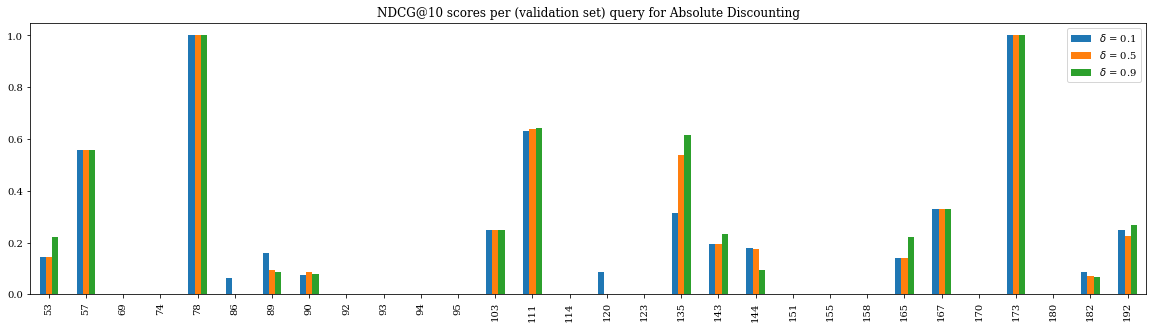

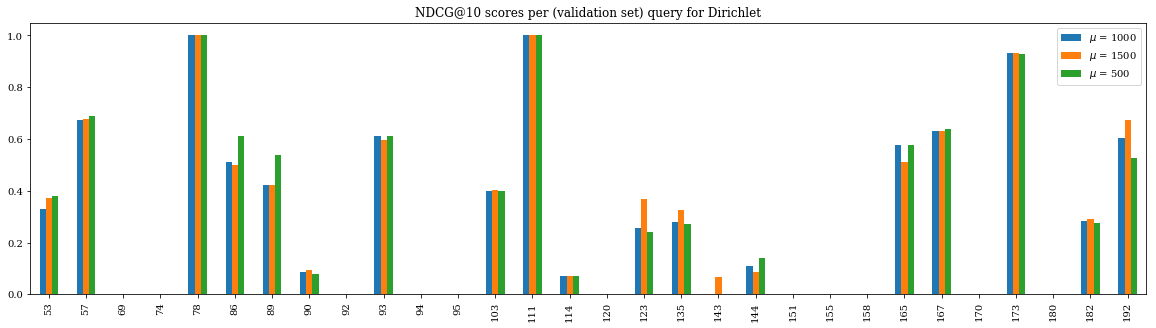

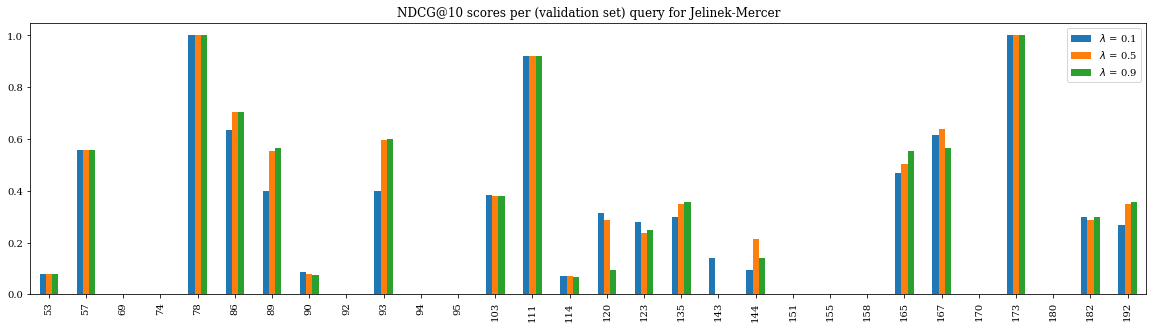

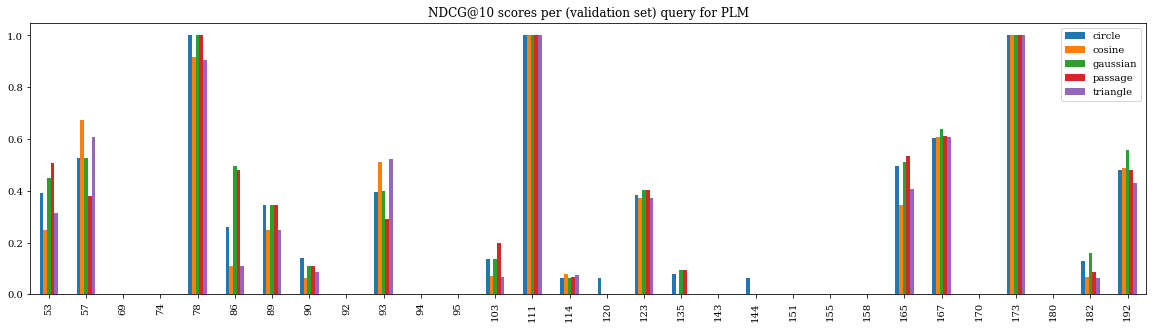

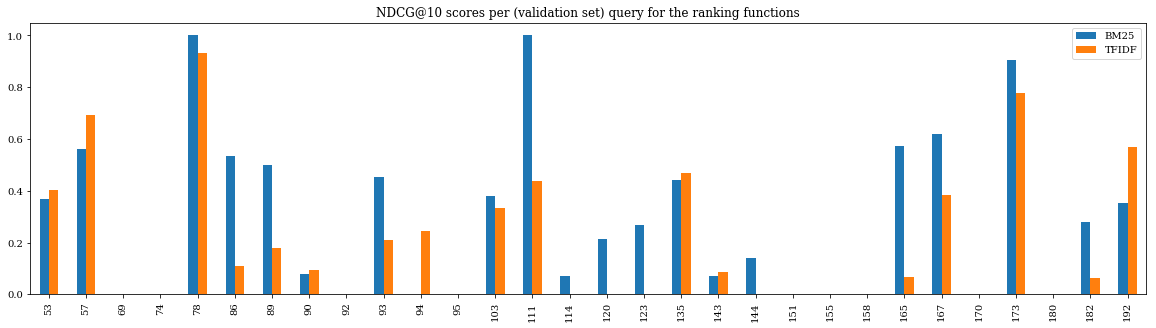

In [7]:
# plots for observing individual query scores in the validation set

for model in language_models.keys():
    if model in ['absolute_discounting', 'jelinek_mercer', 'dirichlet']:
        dicts = { settings[setting]['setting'] : eval_dict_validation['ndcg_cut_10'][setting] 
                  for setting in language_models[model] if settings[setting]['setting'] in requested_settings[model] }
    else:
        dicts = { re.search(r'(?<=\_).*(?=\_)', setting).group(0) : eval_dict_validation['ndcg_cut_10'][setting] 
                  for setting in language_models[model] }
    
    ndcg_df = pd.DataFrame.from_dict(dicts) 
    ndcg_df.plot.bar(figsize=(20,5))
    plt.title('NDCG@10 scores per (validation set) query for ' + scoring_methods[model])
    plt.show()

    rank_dicts = { scoring_methods[ranking_function] : eval_dict_validation['ndcg_cut_10'][ranking_function] 
              for ranking_function in ranking_functions }
ndcg_df = pd.DataFrame.from_dict(rank_dicts) 
ndcg_df.plot.bar(figsize=(20,5))
plt.title('NDCG@10 scores per (validation set) query for the ranking functions')
plt.show()

## Plots and statistics on the test set


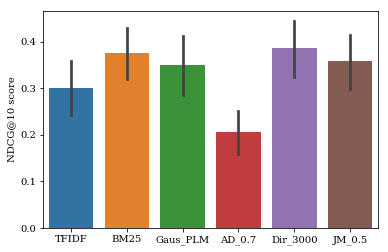

[('TFIDF', 0.30052416666666665), ('BM25', 0.3753675), ('Gaus_PLM', 0.3490708333333333), ('AD_0.7', 0.20655166666666663), ('Dir_3000', 0.3852066666666667), ('JM_0.5', 0.357545)]


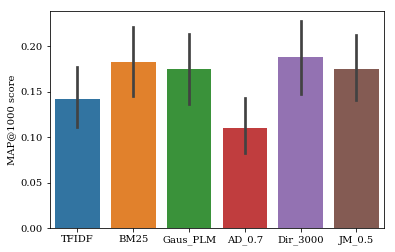

[('TFIDF', 0.1423375), ('BM25', 0.18237166666666665), ('Gaus_PLM', 0.17464583333333333), ('AD_0.7', 0.10962333333333334), ('Dir_3000', 0.18759916666666665), ('JM_0.5', 0.17474499999999998)]


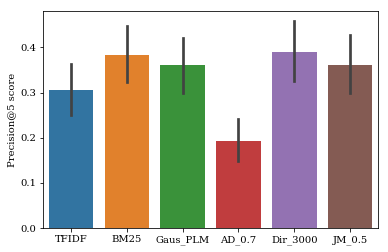

[('TFIDF', 0.305), ('BM25', 0.38333333333333336), ('Gaus_PLM', 0.36000000000000004), ('AD_0.7', 0.19333333333333336), ('Dir_3000', 0.39), ('JM_0.5', 0.3616666666666667)]


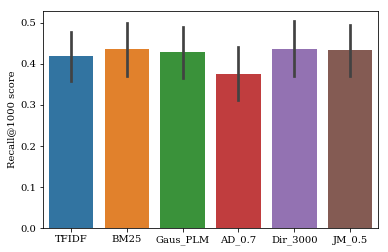

[('TFIDF', 0.4184941666666667), ('BM25', 0.43644083333333333), ('Gaus_PLM', 0.4279116666666667), ('AD_0.7', 0.37552749999999996), ('Dir_3000', 0.4368808333333334), ('JM_0.5', 0.43450500000000003)]


In [8]:
to_compare = { 
    'tfidf' : 'TFIDF',
    'BM25' : 'BM25', 
    'plm_gaussian_3000' : 'Gaus_PLM',
    'absolute_discounting0.7' : 'AD_0.7',
    'dirichlet3000' : 'Dir_3000',
    'jelinek_mercer0.5' : 'JM_0.5'}

for eval_measure in list(eval_dict_validation.keys()):
    data_things = [(to_compare[model], list(scoring_dict_test[model][eval_measure].values())) 
                          for model in to_compare.keys()]
    
    sns.barplot(data=[dat[1] for dat in data_things])
    plt.xticks(np.arange(len(data_things)), [thing[0] for thing in data_things])
    plt.ylabel(eval_measures[eval_measure] + ' score')
    plt.savefig('test_scoring_methods_' + eval_measures[eval_measure] + '.eps', format='eps', dpi=900)
    plt.show()
    
    data_means = [(to_compare[model], np.mean(list(scoring_dict_test[model][eval_measure].values()))) 
                          for model in to_compare.keys()]
    print(data_means)

In [9]:
corrected_pvals_dfs = {}
for eval_measure in eval_measures.keys():
    p_vals = []
    p_vals_corrected = defaultdict(dict)

    for scoring_method_1, scoring_method_2 in combinations(list(to_compare.keys()), 2):
        ttest_result = stats.ttest_rel(list(scoring_dict_test[scoring_method_1][eval_measure].values()), 
                        list(scoring_dict_test[scoring_method_2][eval_measure].values()))

        p_vals.append((ttest_result[1], (scoring_method_1, scoring_method_2)))

    p_list = [p[0] for p in p_vals]
    correction = multipletests(p_list, alpha=0.05, method='sidak')

    for i, p in enumerate(sorted(p_vals)):
        scoring_method_1, scoring_method_2 = p[1]
        if correction[1][i] < 0.05:
            p_vals_corrected[scoring_method_1][scoring_method_2] = '{:.2e}'.format(float(correction[1][i])) + ' *'
        else:
            p_vals_corrected[scoring_method_1][scoring_method_2] = '{:.2e}'.format(float(correction[1][i]))

    corrected_pvals_dfs[eval_measure] = pd.DataFrame.from_dict(p_vals_corrected)

In [10]:
corrected_pvals_dfs['ndcg_cut_10']

,BM25,absolute_discounting0.7,dirichlet3000,plm_gaussian_3000,tfidf
BM25,NaN,NaN,NaN,NaN,1.01e-10 *
absolute_discounting0.7,2.48e-01,NaN,NaN,1.38e-04 *,8.49e-02
dirichlet3000,1.40e-09 *,3.48e-03 *,NaN,9.98e-01,4.56e-01
jelinek_mercer0.5,1.00e+00,1.55e-06 *,1.65e-07 *,1.57e-01,3.52e-01
plm_gaussian_3000,2.08e-11 *,NaN,NaN,NaN,1.51e-02 *


In [12]:
corrected_pvals_dfs['map_cut_1000']

,BM25,absolute_discounting0.7,dirichlet3000,plm_gaussian_3000,tfidf
BM25,NaN,NaN,NaN,NaN,1.47e-08 *
absolute_discounting0.7,7.66e-03 *,NaN,NaN,6.07e-06 *,2.87e-08 *
dirichlet3000,1.14e-06 *,1.48e-04 *,NaN,1.56e-02 *,2.63e-01
jelinek_mercer0.5,1.00e+00,1.17e-02 *,4.76e-01,2.05e-03 *,2.38e-03 *
plm_gaussian_3000,3.57e-09 *,NaN,NaN,NaN,1.04e-06 *


In [13]:
corrected_pvals_dfs['P_5']

,BM25,absolute_discounting0.7,dirichlet3000,plm_gaussian_3000,tfidf
BM25,NaN,NaN,NaN,NaN,1.76e-11 *
absolute_discounting0.7,2.08e-02 *,NaN,NaN,3.81e-03 *,2.42e-01
dirichlet3000,6.54e-10 *,2.75e-01,NaN,1.84e-07 *,9.24e-01
jelinek_mercer0.5,6.57e-01,1.76e-05 *,1.00e+00,7.60e-01,1.00e+00
plm_gaussian_3000,3.12e-10 *,NaN,NaN,NaN,6.84e-01


In [14]:
corrected_pvals_dfs['recall_1000']

,BM25,absolute_discounting0.7,dirichlet3000,plm_gaussian_3000,tfidf
BM25,NaN,NaN,NaN,NaN,2.42e-07 *
absolute_discounting0.7,6.21e-01,NaN,NaN,2.57e-02 *,1.18e-03 *
dirichlet3000,9.47e-01,3.02e-03 *,NaN,1.00e+00,7.32e-02
jelinek_mercer0.5,3.25e-07 *,6.33e-07 *,8.70e-08 *,5.70e-03 *,9.48e-01
plm_gaussian_3000,4.35e-06 *,NaN,NaN,NaN,9.00e-02


In [15]:
# finding 'most interesting' queries
zero_scores = defaultdict(dict)
tfidf_outperforming_bm25 = defaultdict(dict)
large_deltas = defaultdict(dict)

for query_id in test_queries:
    abs_disc_score = eval_dict_test['ndcg_cut_10']['absolute_discounting0.7'][query_id]
    dirichlet_score = eval_dict_test['ndcg_cut_10']['dirichlet3000'][query_id]
    jelinek_merc_score = eval_dict_test['ndcg_cut_10']['jelinek_mercer0.7'][query_id]
    plm_score = eval_dict_test['ndcg_cut_10']['plm_gaussian_3000'][query_id]
    tfidf_score = eval_dict_test['ndcg_cut_10']['tfidf'][query_id]
    bm25_score = eval_dict_test['ndcg_cut_10']['BM25'][query_id]
    
    all_scores = [abs_disc_score, dirichlet_score, jelinek_merc_score, plm_score, tfidf_score, bm25_score]
    
    if all([score == 0. for score in all_scores]):
        zero_scores['query'][query_id] = queries[str(query_id)]
    
    if tfidf_score > bm25_score:
        tfidf_outperforming_bm25['query'][query_id] = queries[str(query_id)]
        tfidf_outperforming_bm25['BM25 score'][query_id] = bm25_score
        tfidf_outperforming_bm25['TFIDF score'][query_id] = tfidf_score
        
    if abs(bm25_score - tfidf_score) > 0.5:
        large_deltas['query'][query_id] = queries[str(query_id)]
        large_deltas['BM25 score'][query_id] = bm25_score
        large_deltas['TFIDF score'][query_id] = tfidf_score
        
zero_scores_df = pd.DataFrame.from_dict(zero_scores)
tfidf_outperforming_bm25_df = pd.DataFrame.from_dict(tfidf_outperforming_bm25)
large_deltas_df = pd.DataFrame.from_dict(large_deltas)

In [16]:
zero_scores_df

,query
65,Information Retrieval Systems
66,Natural Language Processing
67,Politically Motivated Civil Disturbances
76,U.S. Constitution - Original Intent
79,FRG Political Party Positions
80,1988 Presidential Candidates Platforms
87,Criminal Actions Against Officers of Failed Fi...
91,U.S. Army Acquisition of Advanced Weapons Systems
100,Controlling the Transfer of High Technology
105,"""Black Monday"""


In [17]:
tfidf_outperforming_bm25_df

,BM25 score,TFIDF score,query
55,0.2470,0.2844,Insider Trading
64,0.0000,0.6325,Hostage-Taking
70,0.6214,0.7968,Surrogate Motherhood
73,0.0636,0.1100,Demographic Shifts across National Boundaries
75,0.0663,0.0948,Automation
85,0.8900,1.0000,Official Corruption
88,0.0948,0.1420,Crude Oil Price Trends
97,0.3558,0.4284,Fiber Optics Applications
99,0.1331,0.6434,Iran-Contra Affair
110,0.4226,0.6215,Black Resistance Against the South African Gov...


In [18]:
large_deltas_df

,BM25 score,TFIDF score,query
64,0.0000,0.6325,Hostage-Taking
68,0.5290,0.0000,Health Hazards from Fine-Diameter Fibers
71,0.7289,0.0000,Border Incursions
99,0.1331,0.6434,Iran-Contra Affair
148,0.5984,0.0948,Conflict in the Horn of Africa
174,1.0000,0.4164,Hazardous Waste Cleanup


### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [ ]:
#first obtain an initial top-1000 ranking for each query using TF-IDF in Task 1
docx = {}
keys = inverted_index.keys()
start_time = time.time()

print('Computing took: ')

for k in keys:
    docx[k] = inverted_index[k].keys()

scores = {}
top1000_tfidf = {}

#create datasets to store scores and document ids separately
for query_id, term_idx in tokenized_queries.items():
    scores[query_id] = []
    docx_set = set()

    for term_id in term_idx:
        docx_set = docx_set | set(docx[term_id])

#compute tfids scores
    for d_id in docx_set:
        result = 0
        for term_id in term_idx:
            result += tfidf(d_id, term_id, len(inverted_index.get(term_id, 0)), num_documents)
        scores[query_id].append((result, index.document(d_id)[0], d_id))  

print(time.time() - start_time, 'seconds.')

In [ ]:
#store top 1000 tfidf rank queries
for query_id, term_idx in tokenized_queries.items():
    top1000_tfidf[query_id] = sorted(scores[query_id], key = itemgetter(0), reverse = True)
    del top1000_tfidf[query_id][1000:]

#pprint(top1000_tfidf)

# LSMs

In [ ]:
# Use pyndri and gensim to create LSM Models
document = index.document(index.document_base())

# indri to get sentences
sentences = pyndri.compat.IndriSentences(index, dictionary)

# building corpus from sentences
if os.path.exists('run_files/tharangni.dict'):
    dictionary_corpus = gensim.corpora.Dictionary.load('run_files/tharangni.dict')
else:
    dictionary_corpus = gensim.corpora.Dictionary(sentences)
    dictionary_corpus.save('run_files/tharangni.dict')

In [ ]:
# type(list(dictionary_corpus.token2id.items())[267317][1])
print(dictionary_corpus)

In [ ]:
## convert tokenized documents to vectors [DOCUMENT BOW]
if os.path.exists('run_files/tharangni.mm'):
    corpus = gensim.corpora.MmCorpus('run_files/tharangni.mm')
    print('Using already saved BOW')
else:
    corpus = [dictionary_corpus.doc2bow(sentence) for sentence in sentences]
    gensim.corpora.MmCorpus.serialize('run_files/tharangni.mm', corpus) ##<-- saves bow to disk
    print('BOW saved to disk')

In [ ]:
#representation for q (query) [QUERY BOW]
query_bow = []

#query id and term id in tokenized queries
for q_id, t_id in tokenized_queries.items():
    word_at_term = [id2token[t] for t in t_id]
    query_bow.append(dictionary_corpus.doc2bow(word_at_term))

#### LSI

In [ ]:
#train transformation model for LSI
if os.path.exists('run_files/lsi_second_train100'):
    lsi_train = gensim.models.LsiModel.load('run_files/lsi_second_train100') #load model from disk
    print('Using already saved LSI Model')
else:
    lsi_train = gensim.models.LsiModel(corpus=corpus, id2word=dictionary_corpus, num_topics=200, distributed=False)
    lsi_train.save('run_files/lsi_second_train100')  #save model to disk

In [ ]:
lsi_train.print_topics(5)

In [ ]:
def convert2vec_lsi(representation):
    vector = np.zeros(lsi_train.num_topics, dtype=float)
    for element in representation:
        vector[element[0]] = element[1]
    return vector

In [ ]:
DOC_lsi = lsi_train[corpus]
QUERY_lsi = lsi_train[query_bow]

In [ ]:
#create query and document representation
'''
THIS TAKES A LOT OF TIME TO RUN/EXECUTE!
'''
lsi_document_representation = {}
lsi_cosine_similarity = {}

for doc_lsi_term, doc_lsi_id in (zip(DOC_lsi, range(index.document_base(), index.maximum_document()) )):
    lsi_document_representation[doc_lsi_id] = doc_lsi_term

In [ ]:
for query_lsi_id, query_lsi_term in (zip(tokenized_queries.items(), QUERY_lsi)):
    lsi_cosine_similarity[query_lsi_id[0]] = []
    query_lsi_representation = convert2vec_lsi(query_lsi_term)

#re-ranking the top 1000 tfidf queries using lsi
    for value in top1000_tfidf[query_lsi_id[0]]:
#         print(value,'****---****' ,top1000_tfidf[query_lsi_id[0]])
        d = lsi_document_representation[value[2]]
        document_lsi_representation = convert2vec_lsi(d)
        lsi_cosine_similarity[query_lsi_id[0]].append((
            cosine_similarity(query_lsi_representation.reshape(1,-1), document_lsi_representation.reshape(1, -1) )[0][0],
            index.document(value[2])[0]))

In [ ]:
#Create a run file for the LSI model
write_run(model_name='lsi_cosine',
          data=lsi_cosine_similarity,
          out_f=open('run_files/lsi_cosine_tfidf.run', 'w'),
          max_objects_per_query=1000)

#### LDA 

In [ ]:
##### train transformation model for LDA
if os.path.exists('run_files/lda_second_train100'):
    lda_train = gensim.models.ldamulticore.LdaMulticore.load('run_files/lda_second_train100') #load model from disk
    print('Using already saved LDA Model')
else:
#    lda_train = gensim.models.LdaModel(corpus=corpus, id2word=dictionary_corpus, num_topics=100)
    lda_train = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, id2word=dictionary_corpus, num_topics=40, 
                                                        workers=3, passes=1, eval_every=1000, iterations=5,
                                                       batch=False, alpha='symmetric', minimum_probability=0.1,
                                                       chunksize=5000)
    lda_train.save('run_files/lda_second_train100')  #save model to disk


In [ ]:
lda_train.print_topics(5)

In [ ]:
def convert2vec_lda(representation):
    vector = np.zeros(lda_train.num_topics, dtype=float)
    for element in representation:
        vector[element[0]] = element[1]
    return vector

In [ ]:
DOC_lda = lda_train[corpus]
QUERY_lda = lda_train[query_bow]

In [ ]:
#create query and document representation
lda_document_representation = {}
lda_cosine_similarity = {}

for doc_lda_term, doc_lda_id in (zip(DOC_lda, range(index.document_base(), index.maximum_document()) )):
    lda_document_representation[doc_lda_id] = doc_lda_term

In [ ]:
for query_lda_id, query_lda_term in (zip(tokenized_queries.items(), QUERY_lda)):
    lda_cosine_similarity[query_lda_id[0]] = []
    query_lda_representation = convert2vec_lda(query_lda_term)
    
    for value in top1000_tfidf[query_lda_id[0]]:
#         print(value,'****---****' ,top1000_tfidf[query_lsi_id[0]])
        d = lda_document_representation[value[2]]
        document_lda_representation = convert2vec_lda(d)
        lda_cosine_similarity[query_lda_id[0]].append((
            cosine_similarity(query_lda_representation.reshape(1,-1), document_lda_representation.reshape(1, -1))[0][0],
            index.document(value[2])[0]))

In [ ]:
#Create a run file for the LDA model
write_run(model_name='lda_2_cosine',
          data=lda_cosine_similarity,
          out_f=open('run_files/lda_2_cosine_tfidf.run', 'w'),
          max_objects_per_query=1000)

In [20]:
def parse_results(results_file):
    results_lines = [l.strip('\n') for l in open(results_file, 'r').readlines()]
    eval_measure = None
    results_by_scoring = defaultdict(lambda: defaultdict(dict))
    results_by_eval = defaultdict(lambda: defaultdict(dict))
    means = defaultdict(lambda: defaultdict(float))
    
    for line in results_lines:
        if line.startswith('MODEL:'):
            scoring_method = line.split(': ')[1]
            continue
        else:
            eval_measure, query, result = line.split()
            if query == 'all':
                means[eval_measure][scoring_method] = result
            else:
                results_by_scoring[scoring_method][eval_measure][int(query)] = float(result)
                
    for scoring_method in results_by_scoring.keys():
        for eval_measure in results_by_scoring[scoring_method].keys():
            for query, result in results_by_scoring[scoring_method][eval_measure].items():
                results_by_eval[eval_measure][scoring_method][query] = float(result)

    return means, results_by_scoring, results_by_eval
    
means, scoring_dict, eval_dict = parse_results('LSM_results_validation.txt')

language_models = {
    'LSA_models' : [setting for setting in list(means['ndcg_cut_10'])
                   if setting.startswith('lsi_cosine_tfidf') or setting.startswith('lda_2_cosine_tfidf')]}
pprint.pprint(language_models)

{'LSA_models': ['lda_2_cosine_tfidf', 'lsi_cosine_tfidf']}


In [21]:
means_df = pd.DataFrame.from_dict(means)
means_df

,P_5,map_cut_1000,ndcg_cut_10,recall_1000
lda_2_cosine_tfidf,0.0600,0.0378,0.0670,0.1662
lsi_cosine_tfidf,0.1400,0.0596,0.1311,0.1662
tfidf,0.2133,0.1252,0.2016,0.3676


In [22]:
measures = ['P_5', 'map_cut_1000', 'ndcg_cut_10', 'recall_1000']

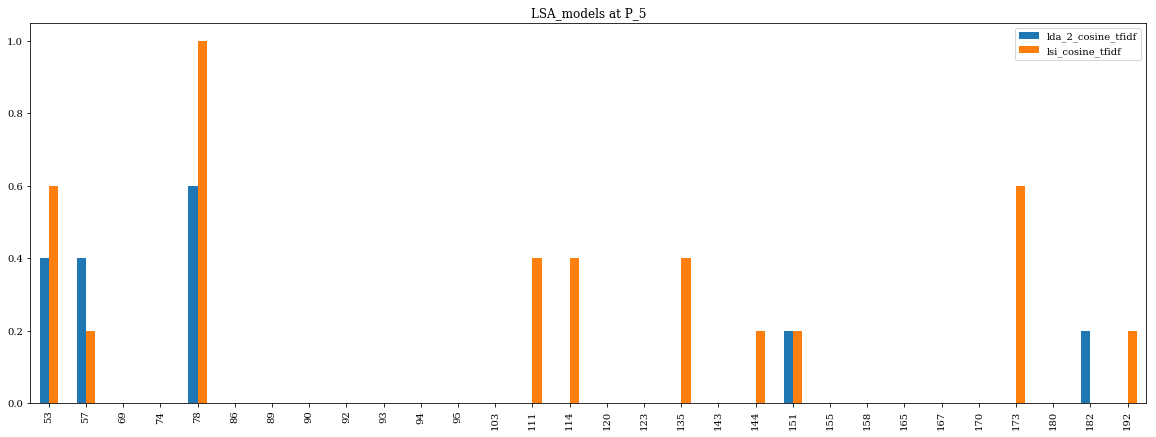

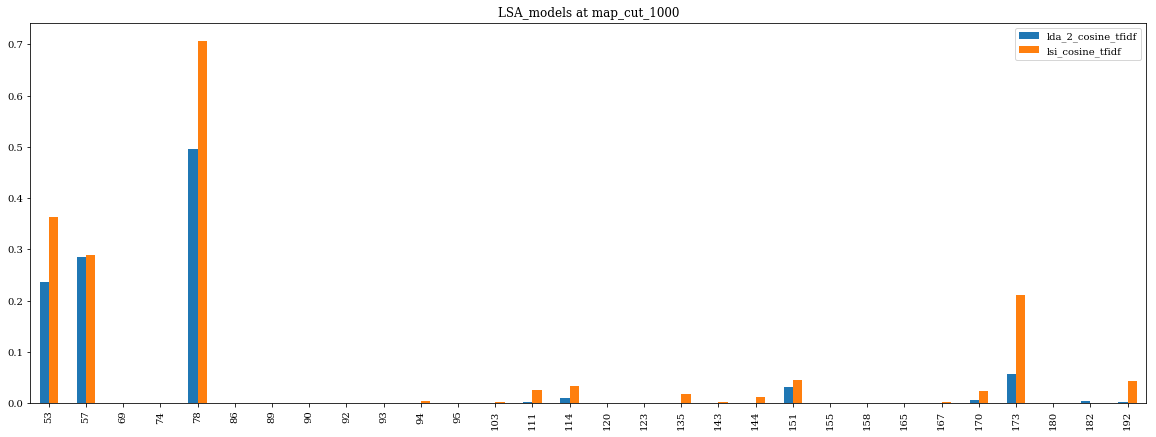

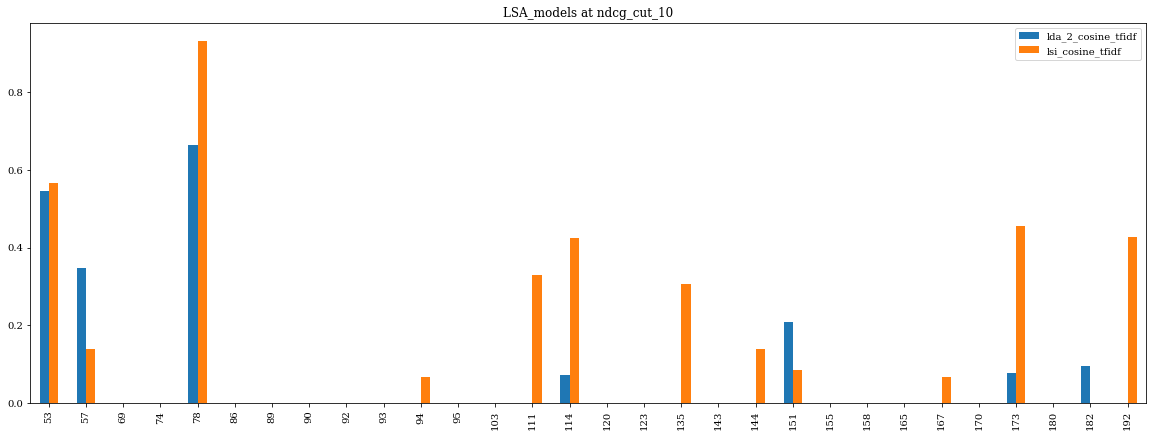

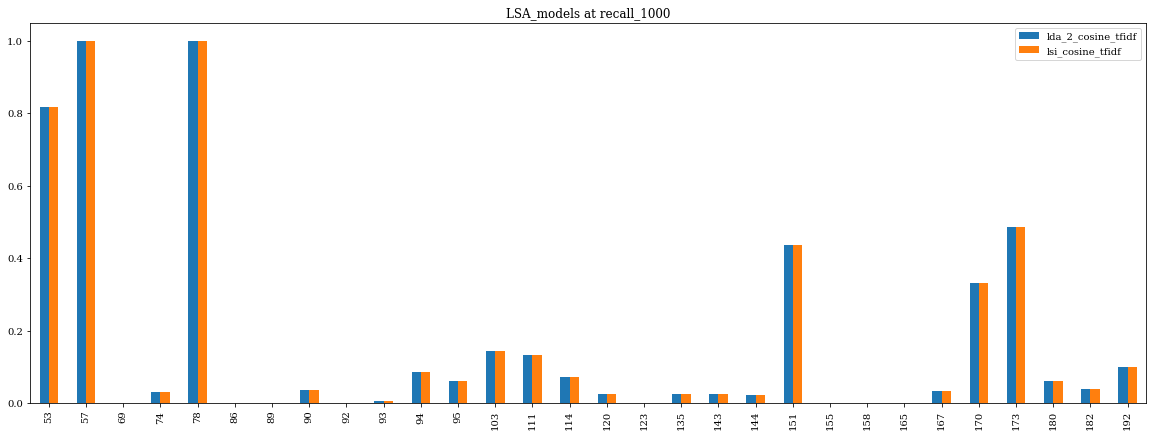

In [23]:
for model in language_models.keys():
    for item in measures:
        dicts = { setting : eval_dict[item][setting] for setting in language_models[model] }
        item_df = pd.DataFrame.from_dict(dicts) 
        item_df.plot.bar(figsize=(20,7))
        plt.title(model + ' at '+item)
        plt.show()
        item_df

In [25]:
#significance testing for LSA models
LSA_ttest = collections.defaultdict(dict)

#storing scores separately as array
for measure in measures:
    LSI_similarity_scores = np.array(list(eval_dict[measure]['lsi_cosine_tfidf'].values()), dtype=float)
    LDA_similarity_scores = np.array(list(eval_dict[measure]['lda_2_cosine_tfidf'].values()), dtype=float)
    #perform t-test
    LSA_ttest[measure] = stats.ttest_rel(LSI_similarity_scores, LDA_similarity_scores)

pprint.pprint(LSA_ttest)
#display pvalues in a table
pvals_df = pd.DataFrame(LSA_ttest)
pvals_df

defaultdict(<class 'dict'>,
            {'P_5': Ttest_relResult(statistic=2.350278605572013, pvalue=0.025774237364825543),
             'map_cut_1000': Ttest_relResult(statistic=2.3544324836780213, pvalue=0.025534906715680324),
             'ndcg_cut_10': Ttest_relResult(statistic=2.2735599955140087, pvalue=0.030576992171964204),
             'recall_1000': Ttest_relResult(statistic=nan, pvalue=nan)})


,P_5,map_cut_1000,ndcg_cut_10,recall_1000
0,2.350279,2.354432,2.273560,NaN
1,0.025774,0.025535,0.030577,NaN


### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [26]:
# Lib:
import copy
import gensim
import logging
import pyndri
import pyndri.compat
from operator import itemgetter
from scipy import spatial
from scipy import stats
import pickle

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")

INFO:root:test


In [27]:
# HELPER FUNCTIONS:

def save_to_file(my_obj, path,obj_name):
    with open(str(path)+str(obj_name)+'.pkl', 'wb') as f:
        pickle.dump(my_obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_from_file(path,obj_name):
    with open(str(path)+str(obj_name), 'rb') as handle:
        b = pickle.load(handle)
    return b


def generate_model(model_id,hyper_param,sentences):
    logging.info('Initializing word2vec.')
    
    word2vec_init = gensim.models.Word2Vec(
    size = hyper_param['size'][model_id],             # Embedding size
    window = hyper_param['window'][model_id],         # One-sided window size
    sg = hyper_param['sg'][model_id],                 # Skip-gram.
    min_count = hyper_param['min_count'][model_id],   # Minimum word frequency.
    sample = hyper_param['sample'][model_id],         # Sub-sample threshold.
    hs = hyper_param['hs'][model_id],                 # Hierarchical softmax.
    negative = hyper_param['negative'][model_id],     # Number of negative examples.
    iter = hyper_param['iter'][model_id],             # Number of iterations.
    workers  =hyper_param['workers'][model_id],       # Number of workers.
    )
    
    word2vec_init.build_vocab(sentences, trim_rule=None)
    models = [word2vec_init]
    for epoch in range(1, 6):
        logging.info('Epoch %d', epoch)

        model = copy.deepcopy(models[-1])
        model.train(sentences,total_examples=164597,epochs=model.iter)
    logging.info('Trained models: %s', model)    
    model_name = str(model_id)+".model"    
    model.save("models/word2vec_models/"+model_name)    

# train word2vec model and save the adress:
def train_word2vec_model(model_num,hyper_param,sentences):
    model_adrs_dict = {}
    for model_id in range(model_num):
        model_name = str(model_id)+".model"
        model_adrs_dict[model_id] = "models/word2vec_models/"+model_name
        if os.path.exists(model_adrs_dict[model_id]):
            continue
        else:
            generate_model(model_id,hyper_param,sentences)
        
    return model_adrs_dict    

def parse_data_set(path):
    file = open(path, 'r')    
    top1000 = collections.defaultdict(list)
    top_docs_set = set()
    for line in file:
        info =line.split()
        top1000[info[0]].append((info[2],info[4]))
        top_docs_set.add(info[2])
    return top1000,top_docs_set


def generate_query2vec(model,top1000,embed_size):
    query2vec = collections.defaultdict(list)
    #------------make vector for the query------------------
    query_vec = {}
    for query_id, query_term in tokenized_queries.items():
        sum_vec = np.zeros(embed_size)
        counter = 0
        for term_id in query_term:
            if term_id > 0 and id2token[term_id] in model :
                sum_vec += np.copy(model[id2token[int(term_id)]])
                counter +=1
        if(counter):
            query_vec[query_id] = sum_vec/counter
    return query_vec 

def generate_doc2vec(model,top_docs_set,embed_size):
    doc_vec = {}
    for doc_ex_id in top_docs_set:
        
        #---------------find doc words---------------
        for indx, doc_info in enumerate(doc_list):
            if doc_info[0] == doc_ex_id:
                doc_terms = doc_info[1]
                doc_id = indx+1
                break                

        sum_vec = np.zeros(embed_size)
        counter = 0
        for term_id in doc_terms:
            if term_id > 0 and id2token[term_id] in model :
                sum_vec += np.copy(model[id2token[int(term_id)]])
                counter +=1
        if(counter):
            doc_vec[doc_ex_id] = sum_vec/counter
    return doc_vec 

def find_cosine_similarity(top1000_tfidf, document2vec, query2vec):
    word2vec_cosine_similarity = collections.defaultdict(list)
    ''' query_id = '93'
    related_docs = top1000_tfidf['93']'''
    for query_id, related_docs in top1000_tfidf.items():
        for doc_info in related_docs: 
            if query_id in query2vec and doc_info[0] in document2vec:
                sim = (1 - spatial.distance.cosine(query2vec[query_id],document2vec[doc_info[0]]),doc_info[0])
                #query_id --> (document_score, external_doc_id)
                word2vec_cosine_similarity[query_id].append((sim))
    return word2vec_cosine_similarity

def write_to_file_word2vec_doc2vec(top1000_list,top_docs_set,model_path,model_num,path_to_save):
    word2vecmodel = {}
    for model_id in range(model_num):
        print(model_id)
        word2vecmodel[model_id]=gensim.models.Word2Vec.load(model_adrs_dict[model_id])#load model
        
        
        if not os.path.exists(str(path_to_save)+ str(model_id)+"_query2vec"):
            query2vec = generate_query2vec(word2vecmodel[model_id],top1000_list,hyper_param['size'][model_id])#make query vectors
            save_to_file(query2vec, path_to_save ,str(model_id)+"_query2vec")
            
            
        if not os.path.exists(str(path_to_save)+ str(model_id)+"_document2vec"):
            document2vec= generate_doc2vec(word2vecmodel[model_id],top_docs_set,hyper_param['size'][model_id])#make doc vectors
            save_to_file(document2vec, path_to_save,str(model_id)+"_document2vec")
        
def generate_word2vec_similarity_file(top1000_list,top_docs_set,model_path,model_num,query_doc_path):   
    for model_id in range(model_num):
        
        model_name = str(model_id)+ '_sim'
        run_out_path = str('models/word2vec_models/') + '{}.run'.format(model_name)
        if os.path.exists(run_out_path):
            return
        
        query2vec = load_from_file(query_doc_path, str(model_id)+'_query2vec.pkl')#load query vectors
        document2vec = load_from_file(query_doc_path, str(model_id)+'_document2vec.pkl')#load doc vector
        word2vec_cosine_similarity = find_cosine_similarity(top1000_list, document2vec, query2vec)#find similarities between queries and docs        

        with open(run_out_path, 'w') as f_out:
            write_run(
                model_name=model_name,
                data=word2vec_cosine_similarity,
                out_f=f_out,
                max_objects_per_query=1000) 



In [ ]:
########## Initialization #############

hyper_param = {
'size' : [32, 32, 32, 32, 64]
,'window' : [20, 10, 20, 5, 15]
,'sg' : [False, True, True, False, False]
,'min_count' : [5, 5, 5, 5, 5]
,'sample' : [1e-3, 1e-3, 1e-3, 1e-3, 1e-3]
,'hs' : [True,True, True, True, True]
, 'negative' : [10, 10, 10, 10, 10]
, 'iter' : [1, 1, 1, 1, 1]
, 'workers' : [8, 8, 8, 8, 8]
}


data_path = 'models/eval/tfidf.run' 
model_path = "models/word2vec_models/"
model_num = 5 #amount of models we have
query_doc_path = 'models/word2vec_models/query_doc_info/'


dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)
logging.info('Initializing word2vec.')

###### BUILD MODELS #######
model_adrs_dict = train_word2vec_model(model_num,hyper_param,sentences)


###### creat word2vec and doc2vec & find similarities ########
top1000_tfidf,top_docs_set = parse_data_set(data_path) 
write_to_file_word2vec_doc2vec(top1000_tfidf,top_docs_set,model_path,model_num,query_doc_path) 
generate_word2vec_similarity_file(top1000_tfidf,top_docs_set,model_path,model_num,query_doc_path)

In [ ]:
# JUST FOR FUN:
from gensim import corpora, models, similarities

model_adrs_dict = {
    0:"0.model"
    ,1: "1.model"
    ,2:"2.model"
    ,3:"3.model"
    , 4:"4.model"
    }

'''word2vecmodel=gensim.models.Word2Vec.load('word2vec_models/0.model')'''
print(id2token[1],word2vecmodel[0][id2token[1]])
word2vecmodel[0].most_similar(id2token[1])
query_doc_path = 'models/word2vec_models/query_doc_info/'
#query2vec = load_from_file(query_doc_path, str(model_id)+'_query2vec.pkl')#load query vectors
query2vec = generate_query2vec(word2vecmodel[0],top1000_tfidf,hyper_param['size'][0])
document2vec = load_from_file(query_doc_path, str(model_id)+'_document2vec.pkl')#load doc vector
word2vec_cosine_similarity = find_cosine_similarity(top1000_tfidf, document2vec, query2vec)

#https://www.youtube.com/watch?v=ERibwqs9p38
#BOW: sentence vector = sum(verctor[each word in sentence])

#another method: vec_sent = len_sent * sum_on_all_words_in_sent( [alpha/(alpha + p(w))] * vec_w)
#Then v_s = v_s - u * u_T * v_s


'''
https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248

 Similarly,
Zuccon et al. [33] leveraged word embeddings for the estima-
tion of translation probability between words, and combine
d
the neural translation language model with collection back
-
ground probabilities using the Dirichlet smoothing strate
gy.
All the existing work shows that employing word embed-
ding for IR can improve retrieval effectiveness.  However,
this is achieved by linearly combining an embedding based
model with traditional retrieval models.
'''

### Word2vec Analysis:

In [28]:
import pprint
from collections import defaultdict

def parse_results(results_file):
    results_lines = [l.strip('\n') for l in open(results_file, 'r').readlines()]
    eval_measure = None
    results_by_scoring = defaultdict(lambda: defaultdict(dict))
    results_by_eval = defaultdict(lambda: defaultdict(dict))
    means = defaultdict(lambda: defaultdict(float))
    
    for line in results_lines:
        if line.startswith('MODEL:'):
            scoring_method = line.split(': ')[1]
            continue
        else:
            eval_measure, query, result = line.split()
            if query == 'all':
                means[eval_measure][scoring_method] = result
            else:
                results_by_scoring[scoring_method][eval_measure][int(query)] = float(result)
                
    for scoring_method in results_by_scoring.keys():
        for eval_measure in results_by_scoring[scoring_method].keys():
            for query, result in results_by_scoring[scoring_method][eval_measure].items():
                results_by_eval[eval_measure][scoring_method][query] = float(result)

    return means, results_by_scoring, results_by_eval
    
means, scoring_dict, eval_dict = parse_results('results_word2vec_validation.txt')



language_models = {
    '_sim' : [setting for setting in list(means['ndcg_cut_10']) 
                              if setting.startswith('0_sim') or setting.startswith('1_sim') or setting.startswith('2_sim') or setting.startswith('3_sim') or setting.startswith('4_sim')]
}


#pprint(language_models)

In [29]:
from itertools import product
from itertools import combinations
from scipy import stats
from statsmodels.sandbox.stats import multicomp
np.random.seed(12345678)

relevance_grades  = ['s0', 's1', 's2', 's3', 's4']
rankings = [ranking for ranking in combinations(relevance_grades, 2)]
print(rankings)

[('s0', 's1'), ('s0', 's2'), ('s0', 's3'), ('s0', 's4'), ('s1', 's2'), ('s1', 's3'), ('s1', 's4'), ('s2', 's3'), ('s2', 's4'), ('s3', 's4')]


In [30]:
#['ndcg_cut_10', 'map_cut_1000', 'recall_1000', 'P_5']
#['4_sim', '3_sim', '2_sim', '0_sim', '1_sim']
#print(eval_dict['ndcg_cut_10']['0_sim'])
'''
S0 AND S4 RECEIVE A NAN PVALUE. WE THINK THIS IS BECAUSE THE NDCG@10 VALUES DON'T SEEM TO BE SIGNIFICANTLY DIFFERENT. 
SO WE CONVERT THIS TO 0 BEFORE PASSING FOR BONFERRONI TEST. AND EVENTUALLY THIS TURNS OUT TO BE THE BEST MODEL.
IN THE END WE CHOOSE S0 (DUE TO 32 EMBEDDING SIZE AND 20 WINDOW SIZE(?)) [CHOOSE THE MODEL WITH LESS FEATURES]
'''
s0_ndcg = np.array(list(eval_dict['ndcg_cut_10']['0_sim'].values()), dtype = float)
s1_ndcg = np.array(list(eval_dict['ndcg_cut_10']['1_sim'].values()), dtype = float)
s2_ndcg = np.array(list(eval_dict['ndcg_cut_10']['2_sim'].values()), dtype = float)
s3_ndcg = np.array(list(eval_dict['ndcg_cut_10']['3_sim'].values()), dtype = float)
s4_ndcg = np.array(list(eval_dict['ndcg_cut_10']['4_sim'].values()), dtype = float)

models_available  = [s0_ndcg, s1_ndcg, s2_ndcg, s3_ndcg, s4_ndcg]
model_combination = [ranking for ranking in combinations(models_available, 2)]
multiple_p_values = [] 

#print(model_combination[0][0], '\n',model_combination[0][1])

for item in model_combination:
    t_test = stats.ttest_rel(item[0],item[1])
    if str(t_test.pvalue) != 'nan':
        multiple_p_values.append(t_test.pvalue)
    else:
        multiple_p_values.append(int(0))
multiple_p_values = np.array(multiple_p_values)

print(multiple_p_values)

#multiple comparisons problem
multiple_comparison = multicomp.multipletests(multiple_p_values, alpha = 0.05, method = 'bonferroni')

print(multiple_comparison)
print(Counter(eval_dict['ndcg_cut_10']['0_sim'].values())[0.0])
print(Counter(eval_dict['ndcg_cut_10']['4_sim'].values())[0.0])


[0.53642468 0.64198782 0.04994218 0.         0.8584213  0.19318518
 0.53642468 0.23711256 0.64198782 0.04994218]
(array([False, False, False,  True, False, False, False, False, False,
       False]), array([1.        , 1.        , 0.49942183, 0.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.49942183]), 0.005116196891823743, 0.005)
12
12


In [31]:
import pandas as pd

means_df = pd.DataFrame.from_dict(means)
means_df

,P_5,map_cut_1000,ndcg_cut_10,recall_1000
0_sim,0.3200,0.1375,0.2895,0.3676
1_sim,0.2667,0.1294,0.2713,0.3676
2_sim,0.2867,0.1297,0.2739,0.3676
3_sim,0.2400,0.1120,0.2339,0.3676
4_sim,0.3200,0.1375,0.2895,0.3676


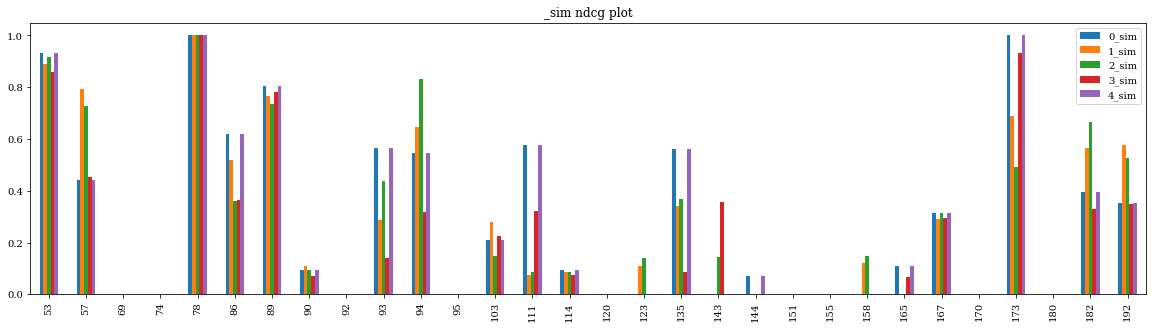

In [32]:
import matplotlib.pyplot as plt
import numpy as np

for model in language_models.keys():
    dicts = { setting : eval_dict['ndcg_cut_10'][setting] for setting in language_models[model] }
    ndcg_df = pd.DataFrame.from_dict(dicts) 
    ndcg_df.plot.bar(figsize=(20,5))
    plt.title(model + ' ndcg plot')
    plt.show()

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.externals import joblib


def get_query_score(score_fn,query_terms, int_doc_id,hyper_param):
    score = 0
    for term_id in query_terms:
        document_term_freq = get_tf(int_doc_id, term_id)
        score += score_fn(int_doc_id, term_id, document_term_freq,hyper_param)
    return score

def load_data(path_file):
    
    file = open(path_file,'r')
    
    num_docs = index.maximum_document() - index.document_base()
    
    #data_set = collections.defaultdict(dict)
    data_list = []
    for line in file:
        info = line.split()
        query_id = info[0]
        label = int(info[3])
        query_terms = tokenized_queries[query_id]
        int_doc_id = ex_to_id.get(str(info[2]),0)
        if int_doc_id != 0:
            data_list.append([float(label), query_id, str(info[2]), get_query_score(tfidf,query_terms, int_doc_id,num_docs),
                                        get_query_score(BM25,query_terms, int_doc_id,[1.2,0.75]),
                                        get_query_score(jelinek_mercer,query_terms, int_doc_id,0.5),
                                        get_query_score(dirichlet,query_terms, int_doc_id,3000),
                                        get_query_score(absolute_discounting,query_terms, int_doc_id,0.7),
                                        len(query_terms),
                                        float(document_lengths[int_doc_id])])
            #data_set[query_id][info[2]] = data_list[-1][3:]            
    return data_list


def normalize_feautures(data_list):
    new_list = list(map(list, zip(*data_list)))
    means = []
    stdv = []    
    
    for i in range(3,len(new_list)):
        means.append(np.mean(new_list[i]))
        stdv.append(np.std(new_list[i])) 
        new_list[i] = np.subtract(new_list[i], float(means[-1]))
        new_list[i] = np.divide(new_list[i], float(stdv[-1]))
    print(means,stdv)
    return means,stdv,list(map(list, zip(*new_list)))

def train_classifier(data_train, label_train, data_valid, label_valid, save_name):
    #clf = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(100, 100, 20, 2), random_state=1)
    clf = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100,50,2), random_state=1)
    #clf = LogisticRegression(max_iter=1000)
    clf.fit(data_train, label_train)
    predictions = np.array(clf.predict(data_valid))
    khar = clf.predict_proba(data_train) 
    #for i in range(10, 20):
    #    print(khar[i, 1], label_train[i], data_train[i])
    correct = np.sum(predictions == label_valid)
    acc = 100.0*float(correct) / ((len(data_valid)))
    #error = np.mean(np.abs(np.subtract(predictions, label_valid)))
    joblib.dump(clf, save_name)
    print("acc: %f" % acc)
    return acc
    


'''def train_classifier(data_train, label_train, data_valid, label_valid, save_name):
    #clf = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(100, 100, 20, 2), random_state=1)
    #clf = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, 20, 2), random_state=1)
    clf = LogisticRegression()
    clf.fit(data_train, label_train)
    predictions = np.array(clf.predict(data_valid))
    correct = np.sum(predictions == label_valid)
    acc = 100.0*float(correct) / ((len(data_valid)))
    #error = np.mean(np.abs(np.subtract(predictions, label_valid)))
    joblib.dump(clf, "_classification_"+save_name)
    print("acc: %f" % acc)
    return acc'''
    

def train_regressor(data_train, label_train, data_valid, label_valid, save_name):
    reg = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 100, 20, 2), random_state=1)
    reg.fit(data_train, label_train)
    predictions = np.array(reg.predict(data_valid))
    error = np.mean(np.abs(np.subtract(predictions, label_valid)))
    joblib.dump(reg, "reg_"+save_name)
    print("MSE: %f" % error)
    
def find_total_relevance_in_train_data(whole_data_list):
    rel_num = 0
    for sample in whole_data_list:
        if sample[0] == 1:
            rel_num += 1
    sample_num = len(whole_data_list)        
    print(float(rel_num)*100/sample_num," % of samples are relevant")
    return sample_num, rel_num

In [ ]:
############### Training and finding accuracy for validation set #################

whole_data_path = './ap_88_89/qrel_validation'#'./ap_88_89/qrel_test'#
whole_data_list = load_data(whole_data_path)
sample_num, rel_num = find_total_relevance_in_train_data(whole_data_list)
means,stdv,whole_data_normalized_list = normalize_feautures(whole_data_list)

In [ ]:
############## shuffle data to eliminate bias #############
np.random.shuffle(whole_data_normalized_list)

In [ ]:
########### fold data #############
#def cross_validation_training(whole_data_normalized_list, itr_num, hyper_param, ):
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics, cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression


ltr_train_model = "2_clf_on_validation_set.pkl"
folding_index = int(0.1*(len(whole_data_normalized_list)))

end = folding_index
begin = 0
validation_acc = []

for i in range(10):
    validation_data = np.array(whole_data_normalized_list[begin:end])
    if begin == 0:   
        train_data = np.array(whole_data_normalized_list[end:])
    else:
        train_data = np.concatenate((np.array(whole_data_normalized_list[:begin]) 
                                 , np.array(whole_data_normalized_list[end:])), axis=0)
    end += folding_index
    begin += folding_index

    train_features = np.array(train_data[:,3:],dtype =float)
    train_labels = np.array(train_data[:,0],dtype =float)

    valid_features = np.array(validation_data[:,3:],dtype =float)
    valid_labels = np.array(validation_data[:,0],dtype =float)

    validation_acc.append(train_classifier(train_features,train_labels,valid_features,valid_labels, str(i)+ltr_train_model))
print("avg:",np.mean(np.array(validation_acc)))

without tfidf:

acc: 83.639032

acc: 83.932502

acc: 83.859134

acc: 82.685253

acc: 82.171680

acc: 83.052091

acc: 83.125459

acc: 84.079237

acc: 84.886280

acc: 82.611886

avg: 83.40425531914892

train on test set:

acc: 76.130856

acc: 77.201131

acc: 76.272213

acc: 76.474152

acc: 76.817447

acc: 77.786753

acc: 76.474152

acc: 75.767367

acc: 76.777060

acc: 75.464459

avg: 76.51655896607433






train on validation:


results of 31 jan run: __lable_train.pkl

acc: 85.326486
    
acc: 83.932502
    
acc: 84.152605
    
acc: 82.905356
    
acc: 85.693324
    
acc: 83.859134
    
acc: 82.391783
    
acc: 83.125459
    
acc: 85.326486
    
acc: 83.565664
    
avg: 84.02787967718268


In [ ]:
test_path = './ap_88_89/qrel_test' #'./ap_88_89/qrel_validation'# 
#ltr_train_model = "0_classification_on_test_set.pkl"

test_data_list = load_data(test_path)
test_sample_num, test_rel_num = find_total_relevance_in_train_data(test_data_list)

new_list = list(map(list, zip(*test_data_list)))
for i in range(3,len(new_list)):
    new_list[i] = np.subtract(new_list[i], float(means[i-3]))
    new_list[i] = np.divide(new_list[i], float(stdv[i-3]))
test_normalized_list = list(map(list, zip(*new_list)))

test_data = np.array(test_normalized_list)

test_features = np.array(np.array(test_data)[:,3:],dtype =float)#(44573, 7)
test_labels = np.array(np.array(test_data)[:,0],dtype =float)#(44573, 1) 

pred = np.zeros((len(test_labels)), dtype=np.float32)
#for i in range(10):

test_clf = joblib.load(str(i)+ltr_train_model)
#pred += test_clf.predict_proba(test_features)[:,1]
pred = test_clf.predict_proba(test_features)[:,1]
#pred /= 10.0
test_predict = np.copy(pred)
th = 0.5
pred[pred>th] = 1
pred[pred<=th] = 0

#for i in range(100):
#    print (pred[i], test_labels[i])
correct = np.sum(pred == test_labels)
acc = float(correct) / (len(pred))
print(acc)

print(pred)

average test accuracy by trained models via 10 distinct folds: 0.7023987400557283

acc of test set for second run on trained model via validation: .7096878407301216

acc of validation set for the run on trained model via test set: 0.7969059315199062

acc of test set for the run on trained model via test set: 0.775855106408755


without tfidf 0.7110810483382466


In [ ]:
data = collections.defaultdict(list)
for indx, item in enumerate(test_normalized_list):
    query_id = item[1]
    #int_doc_id = ex_to_id[item[2]]
    data[query_id].append((test_predict[indx], item[2]))

    
model_name = "50_test_to_validation_ltr_prediction"#'ltr_test_set_prediction'
#str('models/eval/') +
run_out_path =  '{}.run'.format(model_name)

if not os.path.exists(run_out_path):
    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)


In [ ]:
def extract_features(top1000_tfidf):   
    data_list = []
    num_docs = index.maximum_document() - index.document_base()
    for query_id,related_docs in top1000_tfidf.items():
        #print(query_id,related_docs)
        nums = np.zeros(1000)
        nums[:180] = 1
        np.random.shuffle(nums)
        for rank ,info in enumerate(related_docs):
            label = nums[rank]
            query_terms = tokenized_queries[str(query_id)]
            int_doc_id = ex_to_id.get(str(info[0]),0)
            if int_doc_id != 0:
                data_list.append([label,
                                  query_id, str(info[0]), get_query_score(tfidf,query_terms, int_doc_id,num_docs),
                                  get_query_score(BM25,query_terms, int_doc_id,[1.2,0.75]),
                                  get_query_score(jelinek_mercer,query_terms, int_doc_id,0.5),
                                  get_query_score(dirichlet,query_terms, int_doc_id,3000),
                                  get_query_score(absolute_discounting,query_terms, int_doc_id,0.7),
                                  len(query_terms),float(document_lengths[int_doc_id])])
    return data_list

def predict_scores(best_model_name,data_list,means,stdv):
    
    new_list = list(map(list, zip(*data_list)))

    for i in range(3,len(new_list)):
        new_list[i] = np.subtract(new_list[i], float(means[i-3]))
        new_list[i] = np.divide(new_list[i], float(stdv[i-3]))
           
    normalized_list = list(map(list, zip(*new_list)))
    
    preprocessed_data = np.array(normalized_list)
    
    print(preprocessed_data.shape)
        
    features = np.array(np.array(preprocessed_data)[:,3:],dtype =float)
    labels = np.array(np.array(preprocessed_data)[:,0],dtype =float)
    
    new_clf = joblib.load(best_model_name)
    pred = new_clf.predict_proba(features)[:,1]    
    predicted_scores = np.copy(pred)
    
    th = 0.5
    pred[pred>th] = 1
    pred[pred<=th] = 0
    correct = np.sum(pred == labels)
    acc = float(correct) / (len(features))
    
    #write something for recall
    
    print("accuracy",acc)
    
    return predicted_scores, pred

def save_for_trec(model_name,_data_list, predicted_scores):
    
    data = collections.defaultdict(list)
    for indx, item in enumerate(_data_list):
        query_id = item[1]
        ex_doc_id = item[2]
        score = predicted_scores[indx]
        data[query_id].append((predicted_scores[indx], item[2]))
    
    #model_name = 'reranked_tfidf'
    run_out_path =  'models/'+'{}.run'.format(model_name)
    '''if os.path.exists(run_out_path):
        return'''
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

def rerank_run_file(best_model_name,run_file_name,top1000_tfidf,means,stdv):   
    
    data_list = extract_features(top1000_tfidf)
    predicted_scores, pred = predict_scores(best_model_name,data_list,means,stdv)    
    save_for_trec(run_file_name,data_list, predicted_scores)
    
    return data_list, predicted_scores, acc, pred
    

best_model_name ="8"+ltr_train_model#"50_classification_on_test_set.pkl" #'5___label_train.pkl'   
run_file_name = 'reranked_tfidf_' + best_model_name  
data_path = 'run_files/tfidf.run' 
top1000_tfidf,top_docs_set = parse_data_set(data_path)

data_list, predicted_scores, acc, pred = rerank_run_file(best_model_name,run_file_name,top1000_tfidf,means,stdv) 



all zero labels for tfidf: accuracy 0.6592792164054956

-> change in labeling(18% of labels for every query randomly = 1):accuracy 0.7325829566572261 

-> changed the model: "00_classification_on_validation_set.pkl"  accuracy 0.771324466228992

-> change test and validation order:  "50_classification_on_test_set.pkl" 0.7489511227247275

-> without tfidf with hyper 0.5 accuracy 0.7558002710444951  "1_clf_on_validation_set.pkl"